In [23]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from src.utils.Utils import load_csv, load_resultset_json, extract_source, team_name_to_abbr
from src.utils.ConversionUtils import convert_weight_unit, convert_length_unit, convert_human_time
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import os
import pyarrow


In [24]:
random_state = 42
max_imputer_iter = 50

In [25]:
def plot_corr_matrices(input_correlation_matrices, names):
    """
    Plots multiple correlation matrices side by side for comparison.
    """
    num_dfs = len(input_correlation_matrices)
    fig, axes = plt.subplots(1, num_dfs, figsize=(12 * num_dfs, 10))
    if num_dfs == 1:
        axes = [axes]
    for i, df in enumerate(input_correlation_matrices):
        sns.heatmap(df, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[i])
        axes[i].set_title(f"Correlation Matrix - {names[i]}")
    plt.tight_layout()
    plt.show()


In [26]:
# import shot data from CSV files (season 2003-2004 to 2024-2025)
shots_orig = load_csv("../data/shots/*.csv", encoding="utf-8", wildcard=True)

# import anthropometric features from CSV file (season 2000-2001 to 2020-2021)
anthro_2001_2021_orig = load_csv("../data/combine/ANTHRO_FEAT.csv")
# import anthropometric features from JSON files (season 2021-2022 to 2025-2026)
anthro_json_files = glob("../data/RAW/anthro_*.json")
anthro_dfs = [load_resultset_json(file) for file in anthro_json_files]
anthro_2022_2026_orig = pd.concat(anthro_dfs, ignore_index=True)
anthro_2022_2026_orig = anthro_2022_2026_orig.map(extract_source)

# import physical features from CSV file (season 2000-2001 to 2020-2021)
physical_2001_2021_orig = load_csv("../data/combine/PHYSICAL_FEAT.csv")
# import physical features from JSON files (season 2021-2026)
physical_json_files = glob("../data/RAW/physical_*.json")
physical_dfs = [load_resultset_json(file) for file in physical_json_files]
physical_2022_2026_orig = pd.concat(physical_dfs, ignore_index=True)
physical_2022_2026_orig = physical_2022_2026_orig.map(extract_source)

# import draft history data from CSV file
history_orig = load_resultset_json("../data/RAW/history_all.json")

# import schedule and metrics data from CSV file
schedule_metrics_orig = load_csv("../data/RAW/schedule_metrics_2002_2026.csv")

# import event data from CSV files
event_data_orig = load_csv("../data/tracking/events/**/*.csv", encoding="utf-8", wildcard=True)

In [27]:
shots = shots_orig.copy()

shots["SEASON"] = pd.to_numeric(shots["SEASON_1"])
shots["GAME_DATE"] = pd.to_datetime(shots["GAME_DATE"], format="%m-%d-%Y")
shots["IS_3PT"] = shots["SHOT_TYPE"].str.contains("3PT")
shots["MADE_SHOT"] = shots["EVENT_TYPE"].str.contains("Made Shot").astype('bool')
shots["LOC_X_CM"] = pd.to_numeric(shots["LOC_X"].apply(convert_length_unit, input_mode="ft", output_mode="cm"))
shots["LOC_Y_CM"] = pd.to_numeric(shots["LOC_Y"].apply(convert_length_unit, input_mode="ft", output_mode="cm"))
shots["SHOT_DISTANCE_CM"] = pd.to_numeric(
    shots["SHOT_DISTANCE"].apply(convert_length_unit, input_mode="ft", output_mode="cm"))

# update team abbreviations for {'NOK', 'NJN', 'SEA', 'NOH'}
updated_abbr = {
    'NOK': 'NOP',
    'NJN': 'BKN',
    'SEA': 'OKC',
    'NOH': 'NOP'
}
shots["TEAM_NAME"] = shots["TEAM_NAME"].replace(updated_abbr)
shots["HOME_TEAM"] = shots["HOME_TEAM"].replace(updated_abbr)
shots["AWAY_TEAM"] = shots["AWAY_TEAM"].replace(updated_abbr)

shots["TEAM_NAME"] = shots["TEAM_NAME"].apply(team_name_to_abbr).astype('category')
shots["HOME_TEAM"] = shots["HOME_TEAM"].apply(team_name_to_abbr).astype('category')
shots["AWAY_TEAM"] = shots["AWAY_TEAM"].apply(team_name_to_abbr).astype('category')

# combine "MINS_LEFT" and "SECS_LEFT" into "TIME_LEFT_S"
shots["MINS_LEFT"] = pd.to_numeric(shots["MINS_LEFT"])
shots["SECS_LEFT"] = pd.to_numeric(shots["SECS_LEFT"])
shots["TIME_LEFT_S"] = shots["MINS_LEFT"] * 60 + shots["SECS_LEFT"]

shots_final_cols = ["PLAYER_NAME", "PLAYER_ID", "TEAM_ID", "TEAM_NAME", "GAME_ID", "SEASON",
                    "LOC_X_CM", "LOC_Y_CM", "SHOT_DISTANCE_CM", "IS_3PT", "MADE_SHOT", "HOME_TEAM", "AWAY_TEAM",
                    "GAME_DATE", "QUARTER", "TIME_LEFT_S"]
shots = shots[shots_final_cols]
shots

,PLAYER_NAME,PLAYER_ID,TEAM_ID,TEAM_NAME,GAME_ID,SEASON,LOC_X_CM,LOC_Y_CM,SHOT_DISTANCE_CM,IS_3PT,MADE_SHOT,HOME_TEAM,AWAY_TEAM,GAME_DATE,QUARTER,TIME_LEFT_S
0,Anthony Morrow,201627,1610612744,GSW,20801229,2009,-0.000,160.020,0.00,False,True,PHX,GSW,2009-04-15,4,1
1,Kelenna Azubuike,101235,1610612744,GSW,20801229,2009,-0.000,160.020,0.00,False,False,PHX,GSW,2009-04-15,4,9
2,Grant Hill,255,1610612756,PHX,20801229,2009,-0.000,160.020,0.00,False,True,PHX,GSW,2009-04-15,4,25
3,Daniel Gibson,200789,1610612739,CLE,20801219,2009,-6.096,160.020,0.00,False,True,CLE,PHI,2009-04-15,5,4
4,Grant Hill,255,1610612756,PHX,20801229,2009,265.176,230.124,243.84,False,False,PHX,GSW,2009-04-15,4,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205545,Dwight Howard,2730,1610612745,HOU,21400003,2015,30.480,318.516,152.40,False,True,LAL,HOU,2014-10-28,1,683
205546,Tyson Chandler,2199,1610612742,DAL,21400002,2015,30.480,178.308,30.48,False,False,SAS,DAL,2014-10-28,1,692
205547,Tony Parker,2225,1610612759,SAS,21400002,2015,347.472,601.980,548.64,False,False,SAS,DAL,2014-10-28,1,708
205548,Anthony Davis,203076,1610612740,NOP,21400001,2015,-152.400,751.332,609.60,False,False,NOP,ORL,2014-10-28,1,703


In [28]:
min_date = shots["GAME_DATE"].min()
max_date = shots["GAME_DATE"].max()
print(f"Shot Data Date Range: {min_date.date()} to {max_date.date()}")

Shot Data Date Range: 2003-10-28 to 2025-04-13


In [29]:
anthro_final_cols = ["PLAYER_NAME", "POSITION", "HEIGHT_CM", "WEIGHT_KG", "WINGSPAN_CM",
                     "STANDING_REACH_CM", "HAND_LENGTH_CM", "HAND_WIDTH_CM", "BODY_FAT_PCT"]

# SEASON 2022-2026 anthropometric features from JSON files
anthro_2022_2026 = anthro_2022_2026_orig.copy()
select_cols = ["PLAYER_NAME", "POSITION", "HEIGHT_WO_SHOES", "WEIGHT", "WINGSPAN", "STANDING_REACH", "HAND_LENGTH",
               "HAND_WIDTH", "BODY_FAT_PCT"]
anthro_2022_2026 = anthro_2022_2026[select_cols]

anthro_2022_2026["PLAYER_NAME"] = anthro_2022_2026["PLAYER_NAME"].str.strip()

for col in ["HEIGHT_WO_SHOES", "WINGSPAN", "STANDING_REACH", "HAND_LENGTH", "HAND_WIDTH"]:
    anthro_2022_2026[col] = pd.to_numeric(
        anthro_2022_2026[col].apply(convert_length_unit, input_mode="inch", output_mode="cm"))

anthro_2022_2026["WEIGHT"] = pd.to_numeric(
    anthro_2022_2026["WEIGHT"].apply(convert_weight_unit, input_mode="lbs", output_mode="kg"))
anthro_2022_2026["BODY_FAT_PCT"] = pd.to_numeric(
    anthro_2022_2026["BODY_FAT_PCT"].replace(r'^\s*-%\s*$', pd.NA, regex=True).str.replace('%', '', regex=False))
anthro_2022_2026 = anthro_2022_2026.rename(columns={"HEIGHT_WO_SHOES": "HEIGHT_CM",
                                                    "WEIGHT": "WEIGHT_KG",
                                                    "WINGSPAN": "WINGSPAN_CM",
                                                    "STANDING_REACH": "STANDING_REACH_CM",
                                                    "HAND_LENGTH": "HAND_LENGTH_CM",
                                                    "HAND_WIDTH": "HAND_WIDTH_CM"})
anthro_2022_2026 = anthro_2022_2026[anthro_final_cols]

# SEASON 2001-2021 anthropometric features from CSV file
anthro_2001_2021 = anthro_2001_2021_orig.copy()
anthro_2001_2021.columns = ['SEASON', 'PLAYER_NAME', 'POSITION', 'BODY_FAT_PCT', 'HAND_LENGTH_CM',
                            'HAND_WIDTH_CM', 'HEIGHT_CM', 'HEIGHT_SHOES_CM',
                            'STANDING_REACH_CM', 'WEIGHT_KG', 'WINGSPAN_CM']
anthro_2001_2021.replace("-", pd.NA, inplace=True)

anthro_2001_2021["PLAYER_NAME"] = anthro_2001_2021["PLAYER_NAME"].str.strip()

anthro_2001_2021["BODY_FAT_PCT"] = pd.to_numeric(
    anthro_2001_2021["BODY_FAT_PCT"].replace(r'^\s*-%\s*$', pd.NA, regex=True).str.replace('%', '', regex=False))

for col in ["HAND_LENGTH_CM", "HAND_WIDTH_CM"]:
    anthro_2001_2021[col] = pd.to_numeric(
        anthro_2001_2021[col].apply(convert_length_unit, input_mode="inch", output_mode="cm"))

for col in ["HEIGHT_CM", "HEIGHT_SHOES_CM", "STANDING_REACH_CM", "WINGSPAN_CM"]:
    anthro_2001_2021[col] = pd.to_numeric(
        anthro_2001_2021[col].apply(convert_length_unit, input_mode="ft_inch", output_mode="cm"))

anthro_2001_2021["WEIGHT_KG"] = pd.to_numeric(
    anthro_2001_2021["WEIGHT_KG"].apply(convert_weight_unit, input_mode="lbs", output_mode="kg"))

anthro_2001_2021 = anthro_2001_2021[anthro_final_cols]
anthro_complete = pd.concat([anthro_2001_2021, anthro_2022_2026], ignore_index=True)

# split POSITION if "-" in it and duplicate the row with both positions
anthro_complete = anthro_complete.assign(POSITION=anthro_complete["POSITION"].str.split("-")).explode(
    "POSITION").reset_index(drop=True)

# one hot encode POSITION
anthro_complete = pd.get_dummies(anthro_complete, columns=["POSITION"], prefix="POS")

# merge rows / for POSITION, use True if any position is True, else False
anthro_complete = anthro_complete.groupby("PLAYER_NAME", as_index=False).agg({
    "HEIGHT_CM": "mean",
    "WEIGHT_KG": "mean",
    "WINGSPAN_CM": "mean",
    "STANDING_REACH_CM": "mean",
    "HAND_LENGTH_CM": "mean",
    "HAND_WIDTH_CM": "mean",
    "BODY_FAT_PCT": "mean",
    **{col: "max" for col in anthro_complete.columns if col.startswith("POS_")}
})
# make every POS_ column boolean
pos_cols = [col for col in anthro_complete.columns if col.startswith("POS_")]
anthro_complete[pos_cols] = anthro_complete[pos_cols].astype(bool)

anthro_complete

,PLAYER_NAME,HEIGHT_CM,WEIGHT_KG,WINGSPAN_CM,STANDING_REACH_CM,HAND_LENGTH_CM,HAND_WIDTH_CM,BODY_FAT_PCT,POS_C,POS_PF,POS_PG,POS_SF,POS_SG
0,A.J. Granger,201.930,102.965384,207.010,261.62,NaN,NaN,NaN,False,False,False,True,False
1,A.J. Guyton,184.785,79.378600,192.405,247.65,NaN,NaN,NaN,False,False,True,False,True
2,A.J. Price,184.150,87.452538,192.405,246.38,NaN,NaN,12.40,False,False,True,False,False
3,AJ Griffin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,True,False
4,AJ Johnson,193.675,75.749864,204.470,259.08,21.590,21.590,NaN,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1726,Zeke Nnaji,206.375,111.946506,218.440,267.97,22.860,26.670,5.90,True,True,False,False,False
1727,Zhaire Smith,189.865,90.083371,207.645,254.00,22.225,20.955,6.05,False,False,False,True,True
1728,Zhou Qi,216.535,98.973774,233.045,285.75,23.495,24.130,4.85,True,True,False,False,False
1729,Ziaire Williams,203.835,85.456733,208.915,270.51,22.860,22.225,NaN,False,False,False,True,False


In [30]:
# SEASON 2022-2026 physical features from JSON files
physical_final_cols = ["PLAYER_NAME", "LANE_AGILITY_TIME_S",
                       "THREE_QUARTER_SPRINT_S", "STANDING_VERTICAL_LEAP_CM",
                       "MAX_VERTICAL_LEAP_CM"]

physical_2022_2026 = physical_2022_2026_orig.copy()
select_cols = ["PLAYER_NAME", "LANE_AGILITY_TIME", "THREE_QUARTER_SPRINT",
               "STANDING_VERTICAL_LEAP", "MAX_VERTICAL_LEAP", "BENCH_PRESS"]
physical_2022_2026 = physical_2022_2026[select_cols]

physical_2022_2026["PLAYER_NAME"] = physical_2022_2026["PLAYER_NAME"].str.strip()

for col in ["STANDING_VERTICAL_LEAP", "MAX_VERTICAL_LEAP"]:
    physical_2022_2026[col] = pd.to_numeric(
        physical_2022_2026[col].apply(convert_length_unit, input_mode="inch", output_mode="cm"))

physical_2022_2026["LANE_AGILITY_TIME"] = pd.to_numeric(physical_2022_2026["LANE_AGILITY_TIME"])
physical_2022_2026["THREE_QUARTER_SPRINT"] = pd.to_numeric(physical_2022_2026["THREE_QUARTER_SPRINT"])

physical_2022_2026 = physical_2022_2026.rename(columns={"STANDING_VERTICAL_LEAP": "STANDING_VERTICAL_LEAP_CM",
                                                        "MAX_VERTICAL_LEAP": "MAX_VERTICAL_LEAP_CM",
                                                        "LANE_AGILITY_TIME": "LANE_AGILITY_TIME_S",
                                                        "THREE_QUARTER_SPRINT": "THREE_QUARTER_SPRINT_S"})
physical_2022_2026 = physical_2022_2026[physical_final_cols]

# SEASON 2001-2021 physical features from CSV file
physical_2001_2021 = physical_2001_2021_orig.copy()
physical_2001_2021.columns = ['SEASON', 'PLAYER', 'POS', 'LANE_AGILITY_TIME_S',
                              'SHUTTLE_RUN_S', 'THREE_QUARTER_SPRINT_S',
                              'STANDING_VERT_LEAP_CM', 'MAX_VERTICAL_LEAP_CM',
                              'MAX_BENCH_PRESS_REPS']
physical_2001_2021.replace("-", pd.NA, inplace=True)

physical_2001_2021["PLAYER"] = physical_2001_2021["PLAYER"].str.strip()

for col in ["STANDING_VERT_LEAP_CM",
            "MAX_VERTICAL_LEAP_CM"]:
    physical_2001_2021[col] = pd.to_numeric(
        physical_2001_2021[col].apply(convert_length_unit, input_mode="inch", output_mode="cm"))

physical_2001_2021 = physical_2001_2021.rename(columns={"PLAYER": "PLAYER_NAME",
                                                        "STANDING_VERT_LEAP_CM": "STANDING_VERTICAL_LEAP_CM"})

physical_2001_2021["LANE_AGILITY_TIME_S"] = pd.to_numeric(physical_2001_2021["LANE_AGILITY_TIME_S"])
physical_2001_2021["THREE_QUARTER_SPRINT_S"] = pd.to_numeric(physical_2001_2021["THREE_QUARTER_SPRINT_S"])

physical_2001_2021 = physical_2001_2021[physical_final_cols]
physical_complete = pd.concat([physical_2001_2021, physical_2022_2026], ignore_index=True)

# average duplicate PLAYER_NAME entries
physical_complete = physical_complete.groupby("PLAYER_NAME", as_index=False).mean()

physical_complete

,PLAYER_NAME,LANE_AGILITY_TIME_S,THREE_QUARTER_SPRINT_S,STANDING_VERTICAL_LEAP_CM,MAX_VERTICAL_LEAP_CM
0,A.J. Granger,10.73,3.25,76.20,86.36
1,A.J. Guyton,10.55,3.22,83.82,95.25
2,A.J. Price,10.99,3.22,66.04,78.74
3,AJ Griffin,NaN,NaN,NaN,NaN
4,AJ Johnson,10.76,3.15,73.66,96.52
...,...,...,...,...,...
1726,Zeke Nnaji,10.94,3.20,83.82,96.52
1727,Zhaire Smith,11.02,3.05,83.82,105.41
1728,Zhou Qi,11.27,3.46,80.01,81.28
1729,Ziaire Williams,10.69,3.12,86.36,100.33


In [31]:
# merge anthropometric and physical features
combined_features = pd.merge(anthro_complete, physical_complete, on="PLAYER_NAME", how="outer")
# order columns with PLAYER_NAME first, then alphabetically
cols = combined_features.columns.tolist()
cols.remove("PLAYER_NAME")
cols = ["PLAYER_NAME"] + sorted(cols)
combined_features = combined_features[cols]
combined_features

,PLAYER_NAME,BODY_FAT_PCT,HAND_LENGTH_CM,HAND_WIDTH_CM,HEIGHT_CM,LANE_AGILITY_TIME_S,MAX_VERTICAL_LEAP_CM,POS_C,POS_PF,POS_PG,POS_SF,POS_SG,STANDING_REACH_CM,STANDING_VERTICAL_LEAP_CM,THREE_QUARTER_SPRINT_S,WEIGHT_KG,WINGSPAN_CM
0,A.J. Granger,NaN,NaN,NaN,201.930,10.73,86.36,False,False,False,True,False,261.62,76.20,3.25,102.965384,207.010
1,A.J. Guyton,NaN,NaN,NaN,184.785,10.55,95.25,False,False,True,False,True,247.65,83.82,3.22,79.378600,192.405
2,A.J. Price,12.40,NaN,NaN,184.150,10.99,78.74,False,False,True,False,False,246.38,66.04,3.22,87.452538,192.405
3,AJ Griffin,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,True,False,NaN,NaN,NaN,NaN,NaN
4,AJ Johnson,NaN,21.590,21.590,193.675,10.76,96.52,False,False,False,False,True,259.08,73.66,3.15,75.749864,204.470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1726,Zeke Nnaji,5.90,22.860,26.670,206.375,10.94,96.52,True,True,False,False,False,267.97,83.82,3.20,111.946506,218.440
1727,Zhaire Smith,6.05,22.225,20.955,189.865,11.02,105.41,False,False,False,True,True,254.00,83.82,3.05,90.083371,207.645
1728,Zhou Qi,4.85,23.495,24.130,216.535,11.27,81.28,True,True,False,False,False,285.75,80.01,3.46,98.973774,233.045
1729,Ziaire Williams,NaN,22.860,22.225,203.835,10.69,100.33,False,False,False,True,False,270.51,86.36,3.12,85.456733,208.915


In [32]:
# use multivariate normal distribution to impute missing values
mean_imputer = IterativeImputer(random_state=random_state,
                                max_iter=max_imputer_iter,
                                initial_strategy="mean")
median_imputer = IterativeImputer(random_state=random_state,
                                  max_iter=max_imputer_iter,
                                  initial_strategy="median")
numeric_features = combined_features.select_dtypes(include=["number"])

median_features = ["LANE_AGILITY_TIME_S", "THREE_QUARTER_SPRINT_S",
                   "STANDING_VERTICAL_LEAP_CM", "MAX_VERTICAL_LEAP_CM"]

numeric_cols = combined_features.select_dtypes(include=["number"]).columns
mean_features = [col for col in numeric_cols if col not in median_features]

# Copy to avoid mutation
combined_features_imputed = combined_features.copy()

# Impute median_features with median
combined_features_imputed[median_features] = median_imputer.fit_transform(combined_features[median_features])

# Impute mean_features with mean
combined_features_imputed[mean_features] = mean_imputer.fit_transform(combined_features[mean_features])

combined_features_imputed

,PLAYER_NAME,BODY_FAT_PCT,HAND_LENGTH_CM,HAND_WIDTH_CM,HEIGHT_CM,LANE_AGILITY_TIME_S,MAX_VERTICAL_LEAP_CM,POS_C,POS_PF,POS_PG,POS_SF,POS_SG,STANDING_REACH_CM,STANDING_VERTICAL_LEAP_CM,THREE_QUARTER_SPRINT_S,WEIGHT_KG,WINGSPAN_CM
0,A.J. Granger,8.463992,21.994704,23.996756,201.930000,10.730000,86.360000,False,False,False,True,False,261.62000,76.2000,3.250000,102.965384,207.010000
1,A.J. Guyton,5.881492,20.534660,22.347160,184.785000,10.550000,95.250000,False,False,True,False,True,247.65000,83.8200,3.220000,79.378600,192.405000
2,A.J. Price,12.400000,20.259901,21.377563,184.150000,10.990000,78.740000,False,False,True,False,False,246.38000,66.0400,3.220000,87.452538,192.405000
3,AJ Griffin,7.512653,22.143661,23.898410,197.261561,11.397226,87.752228,False,False,False,True,False,262.99653,74.2174,3.275092,97.491501,209.235283
4,AJ Johnson,4.188477,21.590000,21.590000,193.675000,10.760000,96.520000,False,False,False,False,True,259.08000,73.6600,3.150000,75.749864,204.470000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1726,Zeke Nnaji,5.900000,22.860000,26.670000,206.375000,10.940000,96.520000,True,True,False,False,False,267.97000,83.8200,3.200000,111.946506,218.440000
1727,Zhaire Smith,6.050000,22.225000,20.955000,189.865000,11.020000,105.410000,False,False,False,True,True,254.00000,83.8200,3.050000,90.083371,207.645000
1728,Zhou Qi,4.850000,23.495000,24.130000,216.535000,11.270000,81.280000,True,True,False,False,False,285.75000,80.0100,3.460000,98.973774,233.045000
1729,Ziaire Williams,5.058388,22.860000,22.225000,203.835000,10.690000,100.330000,False,False,False,True,False,270.51000,86.3600,3.120000,85.456733,208.915000


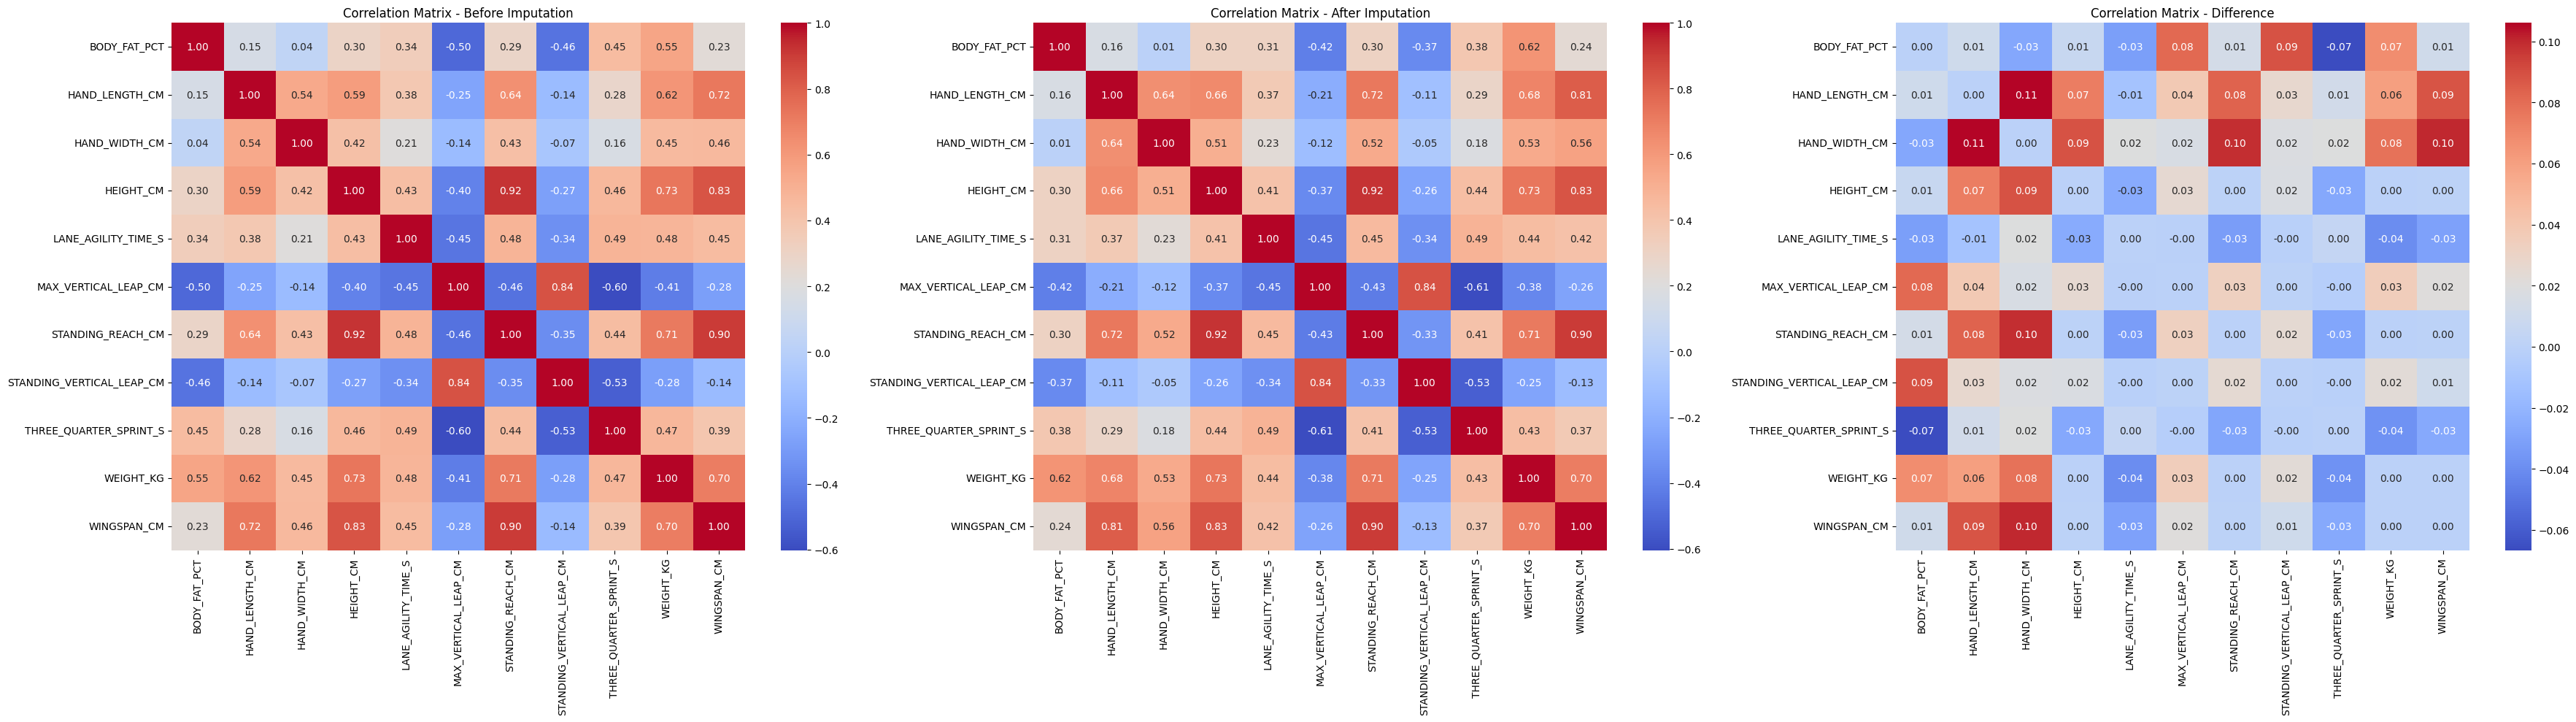

In [33]:
# get difference in correlation matrices before and after imputation
corr_before = combined_features.select_dtypes(include=['number']).corr()
corr_after = combined_features_imputed.select_dtypes(include=['number']).corr()
corr_diff = corr_after - corr_before
plot_corr_matrices([corr_before, corr_after, corr_diff],
                   ["Before Imputation", "After Imputation", "Difference"])

In [34]:
schedule_metrics = schedule_metrics_orig.copy()

schedule_metrics_final_cols = ["SEASON", "GAME_DATE", "HOME_TEAM", "AWAY_TEAM", "TEAM_NAME",
                               "DISTANCE_KM", "REST_D", "TZ_SHIFT",
                               "FLIGHT_TIME_MIN", "LAT", "LON", "D_LAT", "D_LON"]

schedule_metrics.columns = schedule_metrics.columns.str.strip().str.upper().str.replace(" ", "_")
schedule_metrics["DATE"] = pd.to_datetime(schedule_metrics["DATE"], format="%Y-%m-%d")
# select metrics only after max_date
schedule_metrics = schedule_metrics[(schedule_metrics["DATE"] >= min_date) & (schedule_metrics["DATE"] <= max_date)]

# prepare schedule metrics features
schedule_metrics["SEASON"] = pd.to_numeric(schedule_metrics["SEASON"].str.split("-").apply(
    lambda x: "20" + x[1] if len(x) == 2 else x))
schedule_metrics["DISTANCE_KM"] = pd.to_numeric(
    schedule_metrics["DISTANCE"].apply(convert_length_unit, input_mode="miles", output_mode="km"))
schedule_metrics["FLIGHT_TIME_MIN"] = pd.to_numeric(
    schedule_metrics["FLIGHT_TIME"].apply(convert_human_time, output_mode="min"))

schedule_metrics["TEAM_NAME"] = schedule_metrics["TEAM"].apply(team_name_to_abbr).astype('category')
schedule_metrics["OPPONENT"] = schedule_metrics["OPPONENT"].apply(team_name_to_abbr).astype('category')

schedule_metrics["HOME_TEAM"] = np.where(
    schedule_metrics["LOCATION"].str.lower() == "home",
    schedule_metrics["TEAM_NAME"],
    schedule_metrics["OPPONENT"]
)
schedule_metrics["HOME_TEAM"] = schedule_metrics["HOME_TEAM"].astype('category')

schedule_metrics["AWAY_TEAM"] = np.where(
    schedule_metrics["LOCATION"].str.lower() == "home",
    schedule_metrics["OPPONENT"],
    schedule_metrics["TEAM_NAME"]
)
schedule_metrics["AWAY_TEAM"] = schedule_metrics["AWAY_TEAM"].astype('category')

schedule_metrics = schedule_metrics.rename(columns={
    "REST": "REST_D",
    "SHIFT_(HRS)": "TZ_SHIFT",
    "LATITUDE": "LAT",
    "LONGITUDE": "LON",
    "D.LATITUDE": "D_LAT",
    "D.LONGITUDE": "D_LON",
    "DATE": "GAME_DATE"
})

schedule_metrics = schedule_metrics[schedule_metrics_final_cols]

schedule_metrics

,SEASON,GAME_DATE,HOME_TEAM,AWAY_TEAM,TEAM_NAME,DISTANCE_KM,REST_D,TZ_SHIFT,FLIGHT_TIME_MIN,LAT,LON,D_LAT,D_LON
82,2025,2025-04-13,ATL,ORL,ATL,1079.86714,1,0,73.2,33.76,-84.42,40.01,-75.13
83,2025,2025-04-11,PHI,ATL,ATL,125.52852,0,0,55.0,40.01,-75.13,40.67,-73.94
84,2025,2025-04-10,BKN,ATL,ATL,1514.38894,1,0,102.6,40.67,-73.94,28.50,-81.37
85,2025,2025-04-08,ORL,ATL,ATL,653.39204,1,0,55.0,28.50,-81.37,33.76,-84.42
86,2025,2025-04-06,ATL,UTA,ATL,0.00000,0,0,0.0,33.76,-84.42,33.76,-84.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63963,2004,2003-11-07,WAS,TOR,WAS,0.00000,1,0,0.0,38.91,-77.02,38.91,-77.02
63964,2004,2003-11-05,WAS,DAL,WAS,0.00000,3,0,0.0,38.91,-77.02,38.91,-77.02
63965,2004,2003-11-01,WAS,BKN,WAS,563.26900,0,0,55.0,38.91,-77.02,43.65,-79.38
63966,2004,2003-10-31,TOR,WAS,WAS,706.50026,1,1,55.0,43.65,-79.38,41.84,-87.68


In [35]:
# merge schedule metrics with shots data on HOME_TEAN, AWAY_TEAM and DATE
shots_schedule = pd.merge(
    shots, schedule_metrics,
    on=["TEAM_NAME", "HOME_TEAM", "AWAY_TEAM", "GAME_DATE", "SEASON"],
    how="left",
)
shots_schedule

,PLAYER_NAME,PLAYER_ID,TEAM_ID,TEAM_NAME,GAME_ID,SEASON,LOC_X_CM,LOC_Y_CM,SHOT_DISTANCE_CM,IS_3PT,...,QUARTER,TIME_LEFT_S,DISTANCE_KM,REST_D,TZ_SHIFT,FLIGHT_TIME_MIN,LAT,LON,D_LAT,D_LON
0,Anthony Morrow,201627,1610612744,GSW,20801229,2009,-0.000,160.020,0.00,False,...,4,1,1049.28968,1.0,1.0,71.4,33.54,-112.07,37.77,-122.45
1,Kelenna Azubuike,101235,1610612744,GSW,20801229,2009,-0.000,160.020,0.00,False,...,4,9,1049.28968,1.0,1.0,71.4,33.54,-112.07,37.77,-122.45
2,Grant Hill,255,1610612756,PHX,20801229,2009,-0.000,160.020,0.00,False,...,4,25,0.00000,1.0,0.0,0.0,33.54,-112.07,33.54,-112.07
3,Daniel Gibson,200789,1610612739,CLE,20801219,2009,-6.096,160.020,0.00,False,...,5,4,421.64708,1.0,0.0,55.0,41.48,-81.68,39.78,-86.15
4,Grant Hill,255,1610612756,PHX,20801229,2009,265.176,230.124,243.84,False,...,4,63,0.00000,1.0,0.0,0.0,33.54,-112.07,33.54,-112.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4450784,Dwight Howard,2730,1610612745,HOU,21400003,2015,30.480,318.516,152.40,False,...,1,683,2220.88920,15.0,-2.0,150.6,34.11,-118.41,29.77,-95.39
4450785,Tyson Chandler,2199,1610612742,DAL,21400002,2015,30.480,178.308,30.48,False,...,1,692,405.55368,15.0,0.0,55.0,29.46,-98.51,32.79,-96.77
4450786,Tony Parker,2225,1610612759,SAS,21400002,2015,347.472,601.980,548.64,False,...,1,708,0.00000,15.0,0.0,0.0,29.46,-98.51,29.46,-98.51
4450787,Anthony Davis,203076,1610612740,NOP,21400001,2015,-152.400,751.332,609.60,False,...,1,703,0.00000,15.0,0.0,0.0,30.07,-89.93,30.07,-89.93


In [36]:
master_data = pd.merge(shots_schedule, combined_features_imputed, on="PLAYER_NAME", how="left")
semantic_order = [
    "GAME_ID", "GAME_DATE", "SEASON", "QUARTER", "TIME_LEFT_S",
    "HOME_TEAM", "AWAY_TEAM", "TEAM_ID", "TEAM_NAME",
    "PLAYER_ID", "PLAYER_NAME",
    "LOC_X_CM", "LOC_Y_CM", "SHOT_DISTANCE_CM", "IS_3PT",
    "DISTANCE_KM", "REST_D", "TZ_SHIFT", "FLIGHT_TIME_MIN",
    "LAT", "LON", "D_LAT", "D_LON",
    "HEIGHT_CM", "WEIGHT_KG", "WINGSPAN_CM", "STANDING_REACH_CM",
    "HAND_LENGTH_CM", "HAND_WIDTH_CM", "BODY_FAT_PCT",
    "LANE_AGILITY_TIME_S", "THREE_QUARTER_SPRINT_S", "MAX_VERTICAL_LEAP_CM", "STANDING_VERTICAL_LEAP_CM",
    "POS_PG", "POS_SG", "POS_SF", "POS_PF", "POS_C", "MADE_SHOT"
]
master_data = master_data[semantic_order]
master_data

,GAME_ID,GAME_DATE,SEASON,QUARTER,TIME_LEFT_S,HOME_TEAM,AWAY_TEAM,TEAM_ID,TEAM_NAME,PLAYER_ID,...,LANE_AGILITY_TIME_S,THREE_QUARTER_SPRINT_S,MAX_VERTICAL_LEAP_CM,STANDING_VERTICAL_LEAP_CM,POS_PG,POS_SG,POS_SF,POS_PF,POS_C,MADE_SHOT
0,20801229,2009-04-15,2009,4,1,PHX,GSW,1610612744,GSW,201627,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
1,20801229,2009-04-15,2009,4,9,PHX,GSW,1610612744,GSW,101235,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,20801229,2009-04-15,2009,4,25,PHX,GSW,1610612756,PHX,255,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
3,20801219,2009-04-15,2009,5,4,CLE,PHI,1610612739,CLE,200789,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
4,20801229,2009-04-15,2009,4,63,PHX,GSW,1610612756,PHX,255,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4450784,21400003,2014-10-28,2015,1,683,LAL,HOU,1610612745,HOU,2730,...,11.210000,3.140000,90.170000,77.4700,False,False,False,True,True,True
4450785,21400002,2014-10-28,2015,1,692,SAS,DAL,1610612742,DAL,2199,...,12.130000,3.360000,85.090000,78.7400,False,False,True,True,False,False
4450786,21400002,2014-10-28,2015,1,708,SAS,DAL,1610612759,SAS,2225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4450787,21400001,2014-10-28,2015,1,703,NOP,ORL,1610612740,NOP,203076,...,11.397226,3.275092,87.752228,74.2174,False,False,False,True,True,False


In [37]:
# impute missing features in master_data using multivariate normal distribution for combined_features and most frequent for boolean features
master_data_imputed = master_data.copy()
# Impute numeric features with mean imputer
master_data_imputed[mean_features] = mean_imputer.fit_transform(master_data[mean_features])
# Impute median features with median imputer
master_data_imputed[median_features] = median_imputer.fit_transform(master_data[median_features])
# Impute boolean features with most frequent value
bool_cols = master_data.select_dtypes(include=["bool"]).columns
for col in bool_cols:
    most_frequent = master_data[col].mode()[0]
    master_data_imputed[col] = master_data[col].fillna(most_frequent)

master_data_imputed

,GAME_ID,GAME_DATE,SEASON,QUARTER,TIME_LEFT_S,HOME_TEAM,AWAY_TEAM,TEAM_ID,TEAM_NAME,PLAYER_ID,...,LANE_AGILITY_TIME_S,THREE_QUARTER_SPRINT_S,MAX_VERTICAL_LEAP_CM,STANDING_VERTICAL_LEAP_CM,POS_PG,POS_SG,POS_SF,POS_PF,POS_C,MADE_SHOT
0,20801229,2009-04-15,2009,4,1,PHX,GSW,1610612744,GSW,201627,...,11.322491,3.262555,89.011493,75.521687,NaN,NaN,NaN,NaN,NaN,True
1,20801229,2009-04-15,2009,4,9,PHX,GSW,1610612744,GSW,101235,...,11.322491,3.262555,89.011493,75.521687,NaN,NaN,NaN,NaN,NaN,False
2,20801229,2009-04-15,2009,4,25,PHX,GSW,1610612756,PHX,255,...,11.322491,3.262555,89.011493,75.521687,NaN,NaN,NaN,NaN,NaN,True
3,20801219,2009-04-15,2009,5,4,CLE,PHI,1610612739,CLE,200789,...,11.322491,3.262555,89.011493,75.521687,NaN,NaN,NaN,NaN,NaN,True
4,20801229,2009-04-15,2009,4,63,PHX,GSW,1610612756,PHX,255,...,11.322491,3.262555,89.011493,75.521687,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4450784,21400003,2014-10-28,2015,1,683,LAL,HOU,1610612745,HOU,2730,...,11.210000,3.140000,90.170000,77.470000,False,False,False,True,True,True
4450785,21400002,2014-10-28,2015,1,692,SAS,DAL,1610612742,DAL,2199,...,12.130000,3.360000,85.090000,78.740000,False,False,True,True,False,False
4450786,21400002,2014-10-28,2015,1,708,SAS,DAL,1610612759,SAS,2225,...,11.322491,3.262555,89.011493,75.521687,NaN,NaN,NaN,NaN,NaN,False
4450787,21400001,2014-10-28,2015,1,703,NOP,ORL,1610612740,NOP,203076,...,11.397226,3.275092,87.752228,74.217400,False,False,False,True,True,False


In [38]:
master_data.dtypes

GAME_ID                               int64
GAME_DATE                    datetime64[ns]
SEASON                                int64
QUARTER                               int64
TIME_LEFT_S                           int64
HOME_TEAM                          category
AWAY_TEAM                          category
TEAM_ID                               int64
TEAM_NAME                          category
PLAYER_ID                             int64
PLAYER_NAME                          object
LOC_X_CM                            float64
LOC_Y_CM                            float64
SHOT_DISTANCE_CM                    float64
IS_3PT                                 bool
DISTANCE_KM                         float64
REST_D                              float64
TZ_SHIFT                            float64
FLIGHT_TIME_MIN                     float64
LAT                                 float64
LON                                 float64
D_LAT                               float64
D_LON                           

In [39]:
os.makedirs("../datasets/processed", exist_ok=True)

# If you only have this schema, Parquet should work directly!
master_data.to_parquet("../datasets/processed/master_data.parquet", index=False, engine="pyarrow")
master_data_dropped = master_data.dropna()
master_data_dropped.to_parquet("../datasets/processed/master_data_dropped.parquet", index=False, engine="pyarrow")
master_data_imputed.to_parquet("../datasets/processed/master_data_imputed.parquet", index=False, engine="pyarrow")

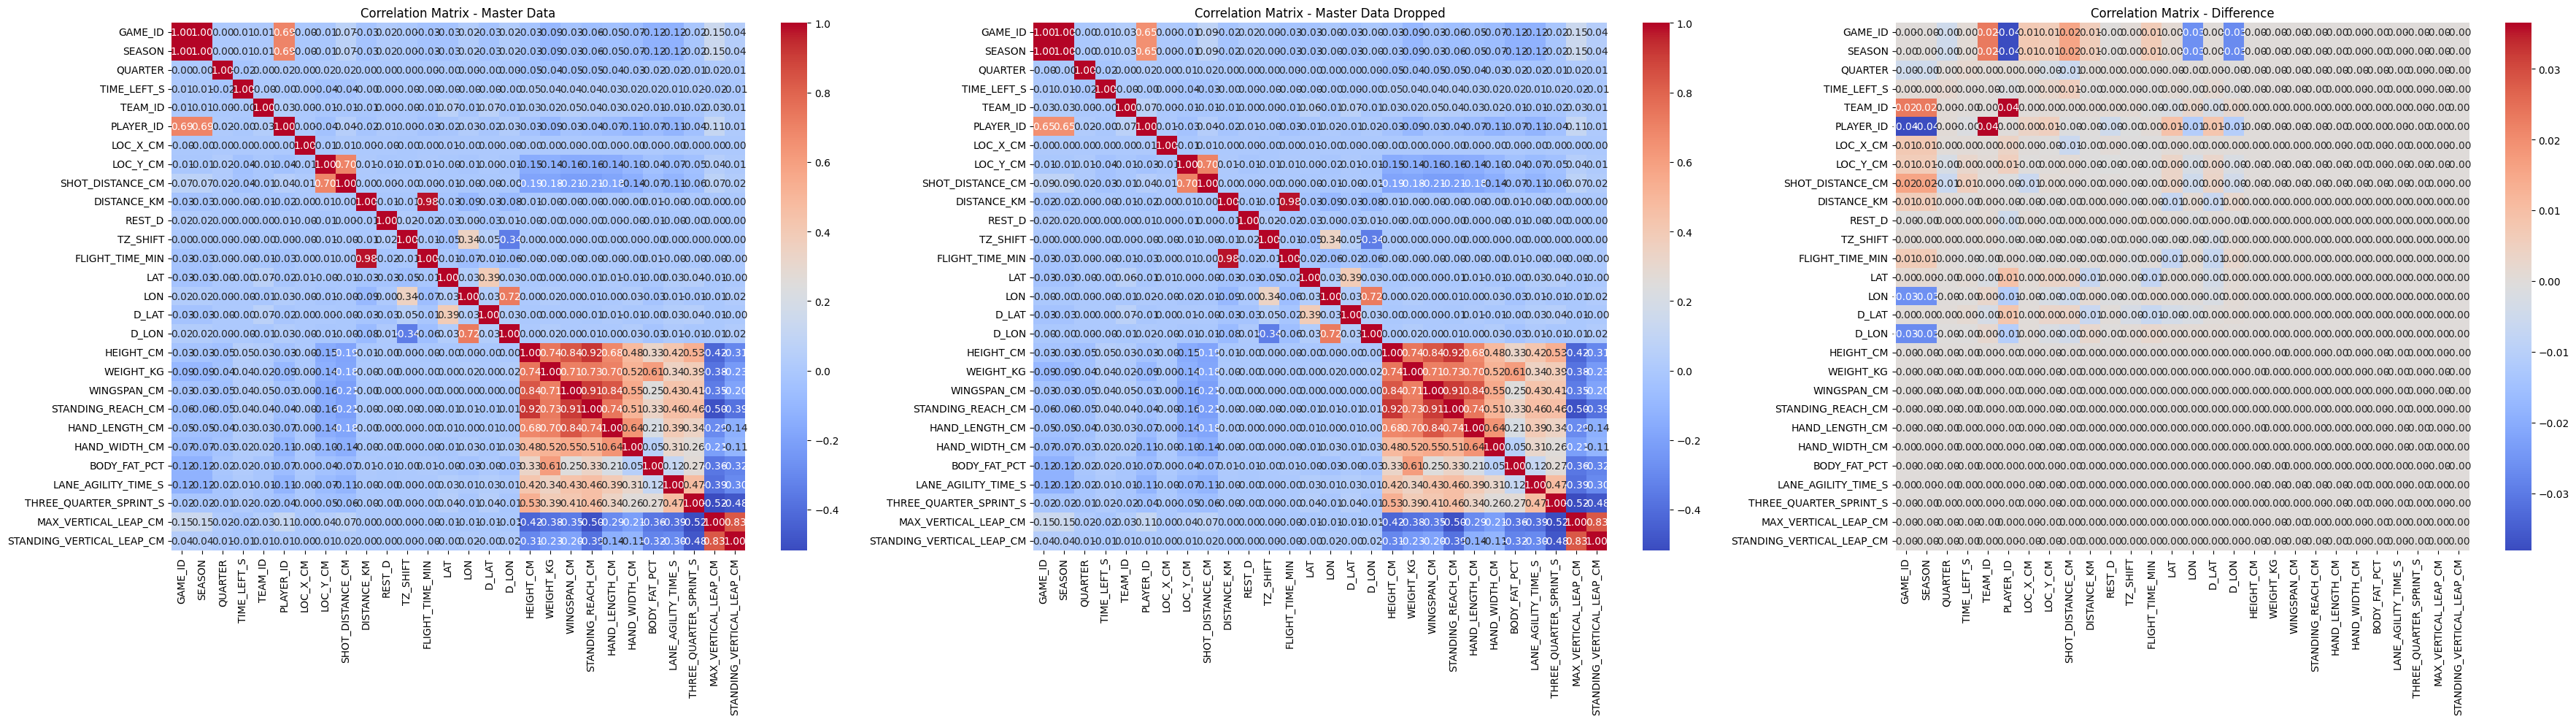

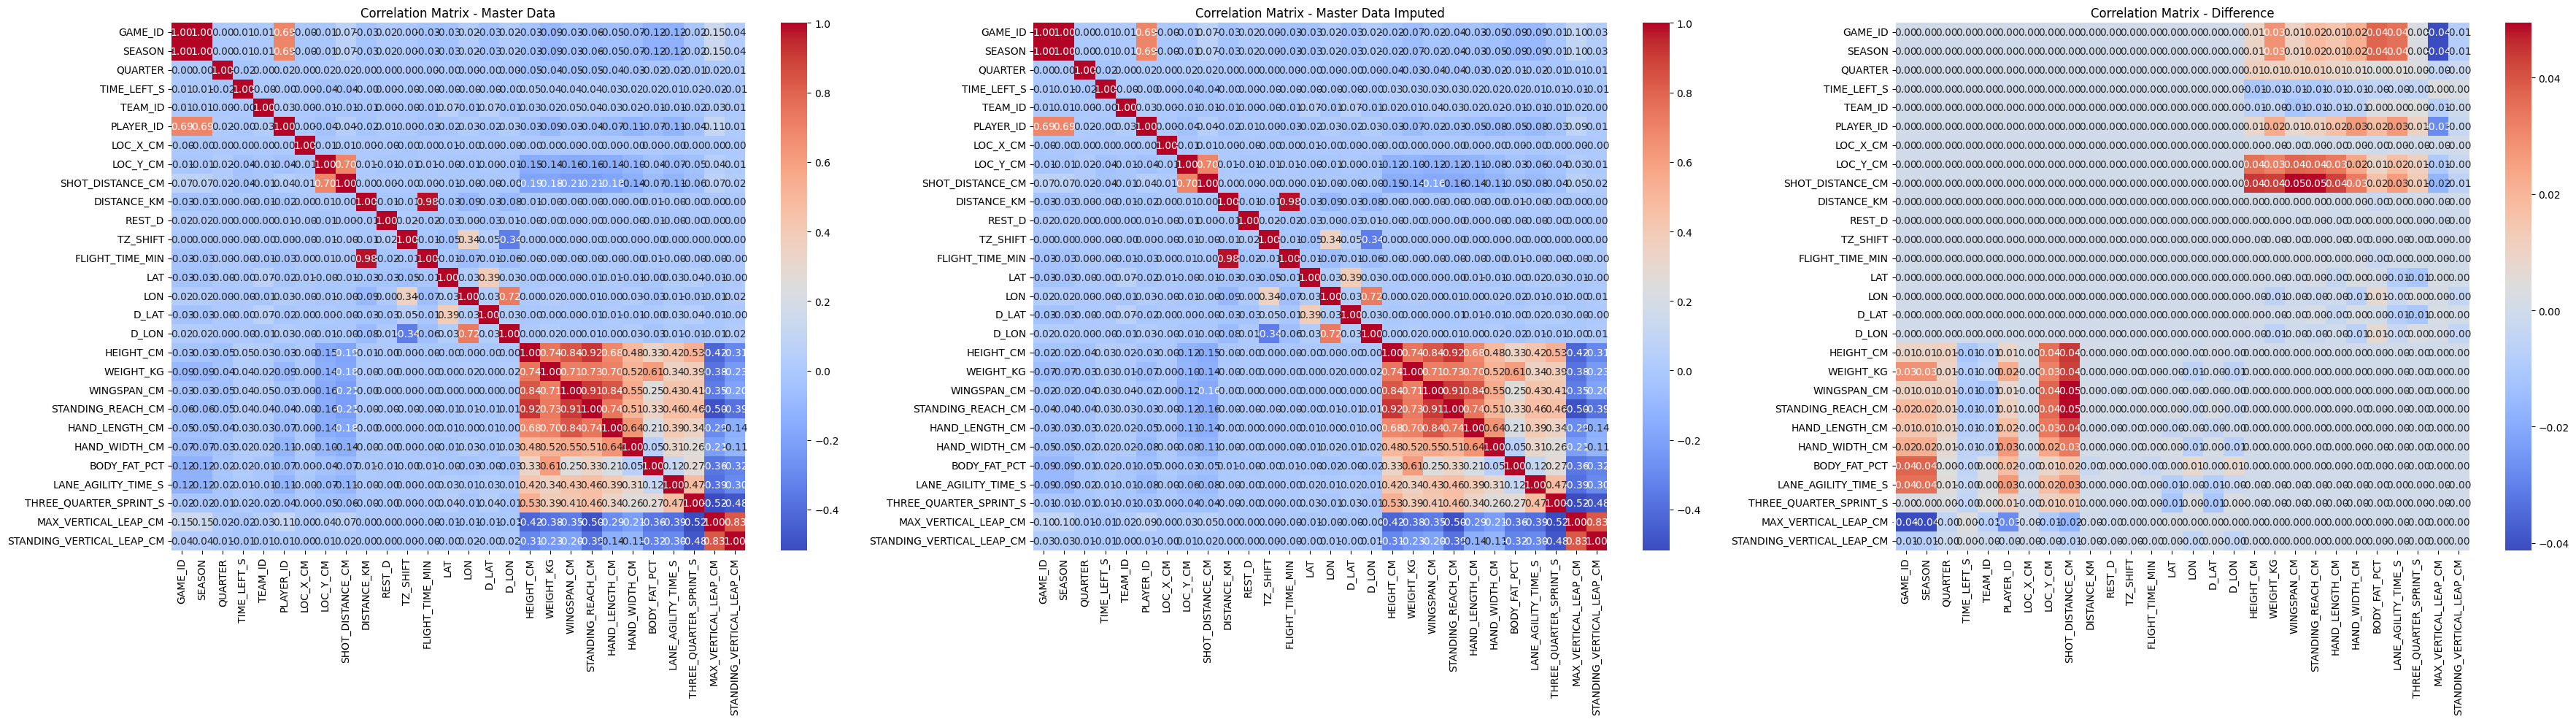

In [40]:
corr_master = master_data.select_dtypes(include=['number']).corr()

# check correlation of matrix between master_data and master_data_dropped
corr_dropped = master_data_dropped.select_dtypes(include=['number']).corr()
corr_diff_dropped = corr_dropped - corr_master
plot_corr_matrices([corr_master, corr_dropped, corr_diff_dropped],
                   ["Master Data", "Master Data Dropped", "Difference"])

# check correlation of matrix between master_data and master_data_imputed
corr_imputed = master_data_imputed.select_dtypes(include=['number']).corr()
corr_diff_imputed = corr_imputed - corr_master
plot_corr_matrices([corr_master, corr_imputed, corr_diff_imputed],
                   ["Master Data", "Master Data Imputed", "Difference"])
